In [6]:
import datasets as hfds

import minai.datasets as minds
import minai.data as mind
import minai.sampler as mins
import minai.plot as minplt
import minai.mintils as mintils

mind.COIOPTS.DEFAULT_DEVICE = "cuda"

minplt.default_cmap("gray")
minplt.default_title_color("white")

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
dsd = minds.hf_load(minds.HF_DATASETS.FASHION_MNIST)

Found cached dataset fashion_mnist (/home/nblzv/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
tdsd = dsd.with_transform(
    mind.HFTransform.ff_img_decode_to_tensor(mind.first_value(dsd).features, n_channels=1, half=True),
).cast_column("image", hfds.Image(decode=False))

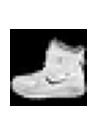

In [10]:
dl = mind.DataLoader.hf(tdsd["train"])
batch = mind.first(dl)
minplt.show_img(batch[0][0], minplt.PlotOpts(title=batch[1][0], figsize=(1, 1)))

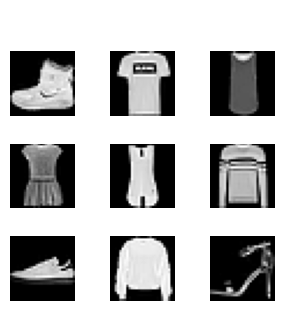

In [11]:
opts = minplt.PlotOpts(rows=3, 
                       cols=3, 
                       figsize=(3, 3),
                       title="Batch",
                       titles=[[x.item(), -x.item()] for x in batch[1]])
minplt.show_batch(batch[0], opts)

In [26]:
dld = mind.DataLoaderDict.hf(tdsd, mind.COPTS(num_threads=1), mins.SIO(256))
dt = dld["train"]
dv = dld["test"]

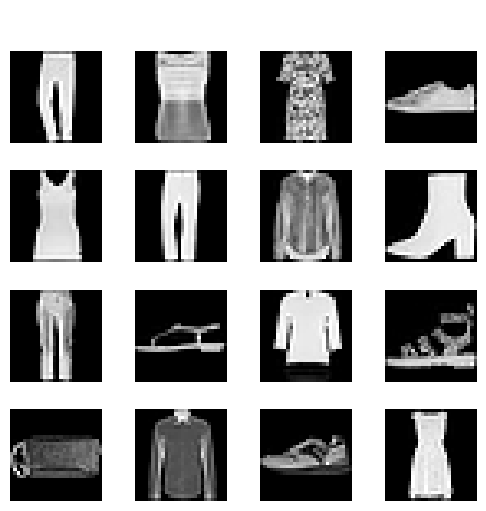

In [27]:
xb, yb = mind.first(dt)

opts = minplt.PlotOpts(rows=4, 
                       cols=4, 
                       figsize=(5, 5),
                       title="Batch",
                       titles=dt.ds.features["label"].int2str(yb))
minplt.show_batch(xb, opts)

In [28]:
from torch import optim
import torch
import torch.nn as nn
import torch.nn.functional as F

lr = 0.4

In [85]:
def conv(inp, out, ks=3, stride=2, act=True):
    res = nn.Conv2d(inp, out, ks, stride, ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def accuracy(preds, yb): 
    return (preds.argmax(1) == yb).float().mean()

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    mintils.push_timing_scope()
    debug_train = 0
    debug_batch = 0
    debug_eval = 0

    for epoch in range(epochs):
        if debug_train: mintils.push_timing_scope()
        model.train()

        if debug_batch: mintils.push_timing_scope()
        for xb, yb in train_dl:
            if debug_batch: mintils.pop_print_timing_scope("batch")

            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
            if debug_batch: mintils.push_timing_scope()
        if debug_batch: mintils.pop_timing_scope()

        if debug_train: mintils.pop_print_timing_scope("train")

        if debug_eval: mintils.push_timing_scope()
        model.eval()
        with torch.no_grad():
            tot_loss = tot_acc = count = 0
            for xb, yb in valid_dl:
                preds = model(xb)

                n = len(xb)
                count += n
                tot_loss += loss_func(preds, yb).item()*n
                tot_acc += accuracy(preds, yb).item()*n
            print(f"{epoch}, {tot_loss/count:.4f}, {tot_acc/count:.4f}")
        if debug_eval: mintils.pop_print_timing_scope("eval")

    mintils.pop_print_timing_scope(f"fit for {epochs} took")
    return tot_loss/count, tot_acc/count

In [86]:
cnn = nn.Sequential(
    conv(1, 4),
    conv(4, 8),
    conv(8, 16),
    conv(16, 16),
    conv(16, 10, act=False),
    nn.Flatten()
).half().to(mind.COIOPTS.DEFAULT_DEVICE)

In [87]:
opt = optim.SGD(cnn.parameters(), lr=lr)
loss, acc = fit(5, cnn, F.cross_entropy, opt, dt, dv)

0, 1.1229, 0.5456
1, 0.5798, 0.7859
2, 0.4964, 0.8195
3, 0.4487, 0.8359
4, 0.4344, 0.8391
fit for 5 took 28.009s
